In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch as t
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from einops.layers.torch import Rearrange

import pandas as pd
import matplotlib.pyplot as plt

from typing import Callable
from tqdm.notebook import tqdm_notebook

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
# testset = datasets.MNIST(root="./data", train=False, transform=transform)
# testloader = DataLoader(testset, batch_size=64)

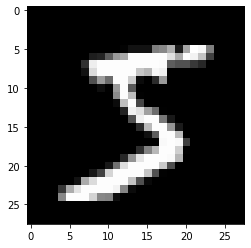

In [4]:
img = trainset[0][0]
plt.imshow(transforms.ToPILImage()(img), cmap='gray', interpolation="nearest")

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_dims=5):
        super().__init__()
        self.latent_dims = latent_dims
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dims),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.ReLU(),
            Rearrange('b (c h w) -> b c h w', c=32, h=7, w=7),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        device = next(self.parameters()).device

        mu, logsigma = self.encoder(x).split(self.latent_dims, -1)
        sigma = t.exp(logsigma)
        epsilon = t.randn_like(sigma).to(device)

        z = mu + sigma * epsilon
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logsigma

In [99]:
class VAE2(nn.Module):

    def __init__(self, latent_dim_size):
        super().__init__()
        self.latent_dim_size = latent_dim_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim_size*2),
            Rearrange("b (n latent_dim) -> n b latent_dim", n=2) # makes it easier to separate mu and sigma
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim_size, 128),
            nn.ReLU(),
            nn.Linear(128, 7 * 7 * 32),
            nn.ReLU(),
            Rearrange("b (c h w) -> b c w h", c=32, h=7, w=7),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        mu, logsigma = self.encoder(x)
        sigma = t.exp(logsigma)
        z = mu + sigma * t.randn(self.latent_dim_size).to(device)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logsigma

In [6]:
device = 'cuda:0' if t.cuda.is_available() else 'cpu'
device

'cuda:0'

In [7]:
def show_images(model, data_to_plot):

    device = next(model.parameters()).device
    data_to_plot = data_to_plot.to(device)
    output = model(data_to_plot)
    if isinstance(output, tuple):
        output = output[0]

    both = t.concat((data_to_plot.squeeze(), output.squeeze()), dim=0).cpu().detach().numpy()
    both = np.clip((both * 0.3081) + 0.1307, 0, 1)

    fig = px.imshow(both, facet_col=0, facet_col_wrap=10, color_continuous_scale="greys_r")
    fig.update_layout(coloraxis_showscale=False).update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
    for i in range(10):
        fig.layout.annotations[i]["text"] = ""
        fig.layout.annotations[i+10]["text"] = str(i)
    fig.show()

In [8]:
data_to_plot = dict()
for data, target in DataLoader(trainset, batch_size=1):
    if target.item() not in data_to_plot:
        data_to_plot[target.item()] = data.squeeze()
        if len(data_to_plot) == 10:
            break
data_to_plot = t.stack([data_to_plot[i] for i in range(10)]).to(t.float).unsqueeze(1)

In [9]:
import numpy as np
import plotly.express as px

In [14]:
def train_vae(
    model,
    optimizer,
    trainloader: DataLoader,
    epochs: int,
    beta: float = 1.0,
    device: str = device,
) -> list:
    '''
    Defines a ConvNet using our previous code, and trains it on the data in trainloader.
    '''
    model.train()
    rec_loss_list = []
    kl_loss_list = []

    for epoch in tqdm_notebook(range(epochs)):
        inner_bar = tqdm_notebook(trainloader, leave=False)
        for x, _ in inner_bar:
            # Get batch
            x = x.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Generate output
            x_prime, mu, logsigma = model(x)

            # Calculate loss
            rec_loss = nn.functional.mse_loss(x, x_prime)
            KL_loss = (-logsigma + 0.5 * (t.exp(logsigma*2) + mu ** 2) - 0.5).mean() * beta
            loss = rec_loss + KL_loss

            # Backprop and step
            loss.backward()
            optimizer.step()

            # Metrics
            rec_loss_list.append(rec_loss.item())
            kl_loss_list.append(KL_loss.item())
            desc_str = f'rl={rec_loss.item() :.4f}, kl={KL_loss.item() :.4f}, loss={loss.item() :.4f}'
            inner_bar.set_description(desc_str)

        # Show images
        with t.inference_mode():
            show_images(model, data_to_plot)

    return rec_loss_list, kl_loss_list

In [15]:
model = VAE().to(device).train()
opt = t.optim.Adam(model.parameters(), weight_decay=1e-5)

In [16]:
rec_loss_list, kl_loss_list = train_vae(model, opt, trainloader, 10, beta=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

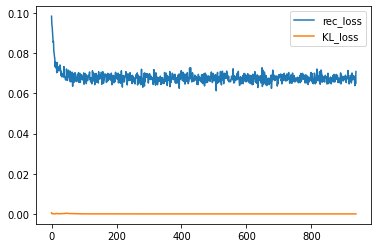

In [127]:
df = pd.DataFrame()
df['rec_loss'] = rec_loss_list
df['KL_loss'] = kl_loss_list
df.plot()

In [128]:
def train_vae2(model, optimizer, loss_fn, trainloader, epochs):

    model.to(device).train()
    recloss_list = []
    klloss_list = []

    for epoch in range(epochs):

        progress_bar = tqdm_notebook(trainloader, leave=False)

        for img, label in progress_bar:

            img = img.to(device)
            img_reconstructed, mu, logsigma = model(img)

            reconstruction_loss = loss_fn(img, img_reconstructed)
            kl_div_loss = ( 0.5 * (mu ** 2 + t.exp(2 * logsigma) - 1) - logsigma ).mean() * 0.1

            loss = reconstruction_loss + kl_div_loss
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            recloss_list.append(reconstruction_loss.item())
            klloss_list.append(kl_div_loss.item())
            progress_bar.set_description(f"Epoch {epoch+1}, reconstruction_loss = {reconstruction_loss.item():>10.3f}, kl_div_loss = {kl_div_loss.item():>10.3f}, mean={mu.mean():>10.3f}, std={t.exp(logsigma).mean():>10.3f}")

    return recloss_list, klloss_list

In [129]:
model2 = VAE2(5).to(device).train()
opt2 = t.optim.Adam(model2.parameters(), weight_decay=1e-5)

In [130]:
recloss_list, klloss_list = train_vae2(model2, opt2, nn.MSELoss(), trainloader, 2)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

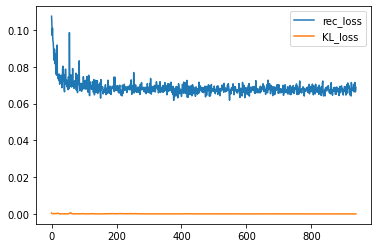

In [131]:
df2 = pd.DataFrame()
df2['rec_loss'] = recloss_list
df2['KL_loss'] = klloss_list
df2.plot()

In [ ]:
# Get samples of each digit eg. imgs[0] has tensor for digit 0
imgs = []
for i in range(10):
    loc_i = (trainset.targets == i).nonzero()[0][0].item()
    imgs.append(trainset[loc_i][0])

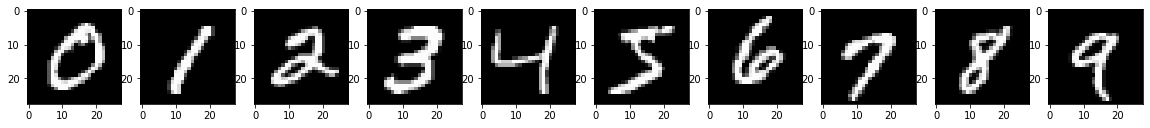

In [ ]:
# Plot original images
fig = plt.figure(figsize=(20, 10))

for i in range(10):
    fig.add_subplot(1, 10, i+1)  
    plt.imshow(transforms.ToPILImage()(imgs[i]), cmap='gray')

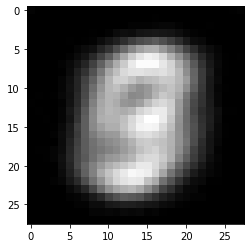

In [112]:
with t.inference_mode():
    rec = model2.decoder(t.randn(1, 5).to(device))[0].view(1, 28, 28)
plt.imshow(transforms.ToPILImage()(rec.clip(0, 1)), cmap='gray')

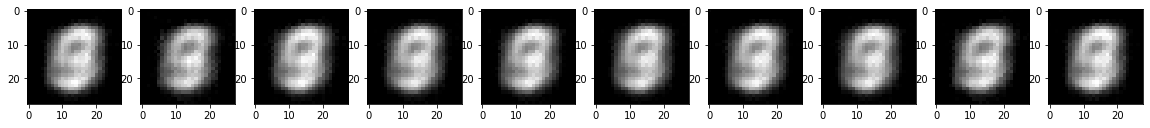

In [ ]:
# Plot reconstructed images
fig = plt.figure(figsize=(20, 10))
model.eval()

for i in range(10):
    with t.inference_mode():
        rec = model(imgs[i].view(1, 1, 28, 28).to(device))[0].view(1, 28, 28)
    fig.add_subplot(1, 10, i+1)  
    plt.imshow(transforms.ToPILImage()(rec.clip(0, 1)), cmap='gray')

In [ ]:
# Widget to explore latent space representation -> reconstruction
import ipywidgets as widgets

@widgets.interact(
    x0=(-5, 5, 0.1),
    x1=(-5, 5, 0.1),
    x2=(-5, 5, 0.1),
    x3=(-5, 5, 0.1),
    x4=(-5, 5, 0.1)
)
def update(x0=0, x1=0, x2=0, x3=0, x4=0):
    """Remove old lines from plot and plot new one"""
    latent_space = [x0, x1, x2, x3, x4]
    z = t.tensor(latent_space).to(device).view(1, 5)
    reconstruction = model.decoder(z).view(1, 28, 28)
    plt.imshow(transforms.ToPILImage()(reconstruction.clip(0, 1)), cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='x0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

In [ ]:
# Get a single batch
for inputs, labels in DataLoader(trainset, batch_size=1000, shuffle=True):
    break

latent = model.encoder(inputs.to(device))

df2 = pd.DataFrame()
df2['label'] = labels.detach().cpu().numpy()
df2['x0'] = latent[:, 0].detach().cpu().numpy()
df2['x1'] = latent[:, 1].detach().cpu().numpy()
df2['x2'] = latent[:, 2].detach().cpu().numpy()
df2['x3'] = latent[:, 3].detach().cpu().numpy()
df2['x4'] = latent[:, 4].detach().cpu().numpy()

In [ ]:
col = df2['label'].map({
    0:'C0',
    1:'C1',
    2:'C2',
    3:'C3',
    4:'C4',
    5:'C5',
    6:'C6',
    7:'C7',
    8:'C8',
    9:'C9',
  })

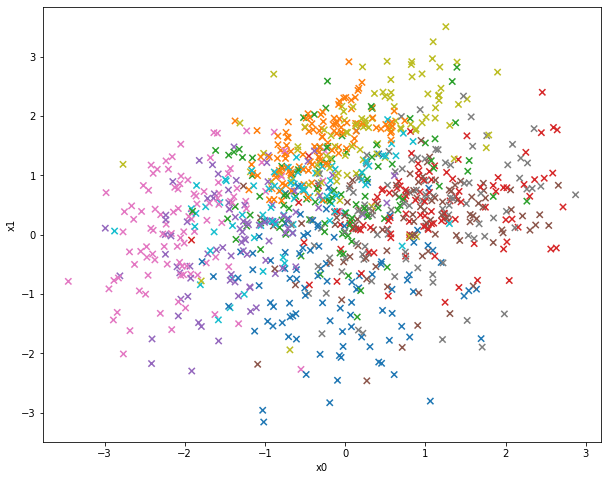

In [ ]:
df2.plot.scatter(x='x0', y='x1', marker='x', s=40, c=col, figsize=(10, 8))